In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib inline

# Import des donneés

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Save train
X_train = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_train.npy', allow_pickle=True)
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_train.npy', allow_pickle=True)
# Save validation
X_val = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_val.npy', allow_pickle=True)
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_val.npy', allow_pickle=True)
# Save test
X_test = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/X_test.npy', allow_pickle=True)
y_test = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/y_test.npy', allow_pickle=True)

In [4]:
X_train.shape, X_val.shape, X_test.shape

((1749, 224, 224, 3), (375, 224, 224, 3), (376, 224, 224, 3))

In [5]:
y_train.shape, y_val.shape, y_test.shape

((1749, 5), (375, 5), (376, 5))

In [6]:
from skimage import exposure
# Histogram equalization
def histogram_equalization(img):
    for channel in range(img.shape[2]):  # equalizing each channel
        img[:, :, channel] = exposure.equalize_hist(img[:, :, channel])
    return img
def reformat_images(arr):
    for idx in range(arr.shape[0]):
        arr[idx] = histogram_equalization(arr[idx])
    return arr

In [7]:
X_train = reformat_images(X_train)
X_val = reformat_images(X_val)
X_test = reformat_images(X_test)

In [8]:
X_train.shape, X_val.shape, X_test.shape

((1749, 224, 224, 3), (375, 224, 224, 3), (376, 224, 224, 3))

# Evaluation des modèles

In [9]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.utils import plot_model

with open('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/saved_model/label_bin.pkl', 'rb') as f:
    lb = pickle.load(f)

display(lb.classes_)

def evaluate_model(model, X_test, y_test, lb):
    ### Predict
    y_pred = [lb.classes_[np.argmax(model.predict(np.expand_dims(_X_test, axis=0)))] for _X_test in X_test]

    #Get the confusion matrix
    cf_matrix = confusion_matrix(lb.inverse_transform(y_test), y_pred)

    plt.figure(figsize=(8,8))
    ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)

    ax.set_title('Confusion Matrix\n');
    ax.set_xlabel('\nPredicted Breed')
    ax.set_ylabel('Expected Breed');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(lb.classes_, rotation=90)
    ax.yaxis.set_ticklabels(lb.classes_, rotation=0)

    ## Display the visualization of the Confusion Matrix.
    plt.show()
    ### Scores
    print('\n\n')
    print(classification_report(y_test,lb.transform(y_pred)))

def plot_training(history):
    plt.subplot()
    plt.title('Model Accuracy')
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['Training Accuracy','Validation Accuracy'])
    plt.show()

    plt.title('Model Loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['Training Loss','Validation Loss'])
    plt.show()

def model_report(model, history, X_test, y_test, lb):
    #plot_model(model, show_shapes=True)
    print(model.summary())
    plot_training(history)
    evaluate_model(model, X_test, y_test, lb)

array(['afghan_hound', 'maltese_dog', 'pomeranian', 'samoyed',
       'scottish_deerhound'], dtype='<U18')

# Parametrage

In [10]:
import tensorflow as tf
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, MaxPooling2D, Conv2D, GlobalMaxPooling2D, LeakyReLU
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

## Parametres
epochs = 50
batch_size = 64

opt = Adam(learning_rate=1e-3)

In [11]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=10,
    verbose=1,
    mode='auto'
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1, 
    mode='auto'
)

callbacks = [earlystop, reduceLR]

#From Scratch VGG16


## Choix layer transition Convolution vers classification

### Layer Flatten

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 30s 665ms/step - loss: 1.6492 - accuracy: 0.2047 - val_loss: 1.6095 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6100 - accuracy: 0.1990 - val_loss: 1.6095 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6096 - accuracy: 0.1950 - val_loss: 1.6094 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 487ms/step - loss: 1.6096 - accuracy: 0.1995 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6094 - accuracy: 0.2035 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6095 - accuracy: 0.1915 - val_loss: 1.6094 - val_accuracy: 0.2080 -

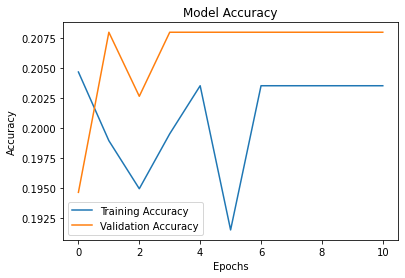

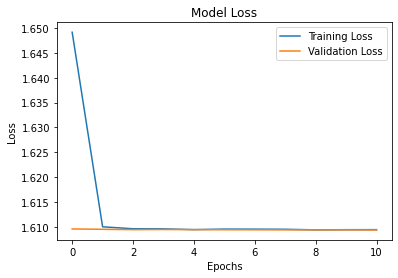

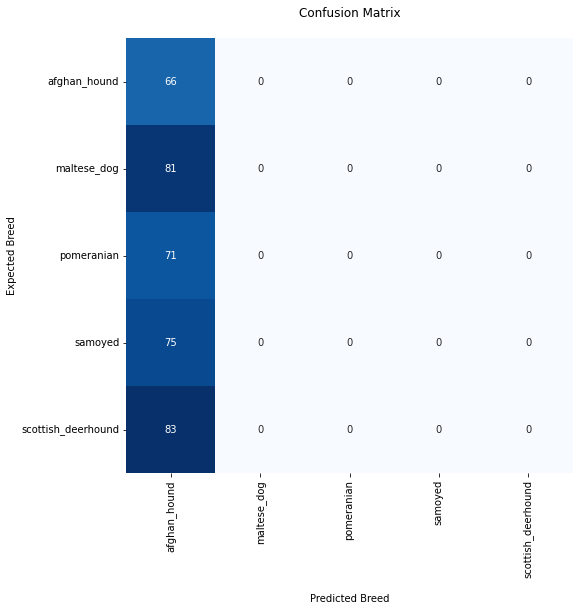




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [12]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Layer GlobalAveragePooling

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 512ms/step - loss: 1.6253 - accuracy: 0.1875 - val_loss: 1.6095 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 486ms/step - loss: 1.6096 - accuracy: 0.2007 - val_loss: 1.6095 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6097 - accuracy: 0.1893 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6095 - accuracy: 0.1933 - val_loss: 1.6094 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6094 - accuracy: 0.1995 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 1.6094 - accuracy: 0.2024
Epoch 6: ReduceLROnPlateau reducing learning rate 

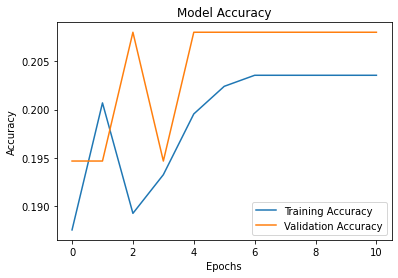

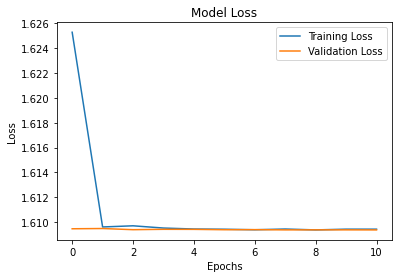

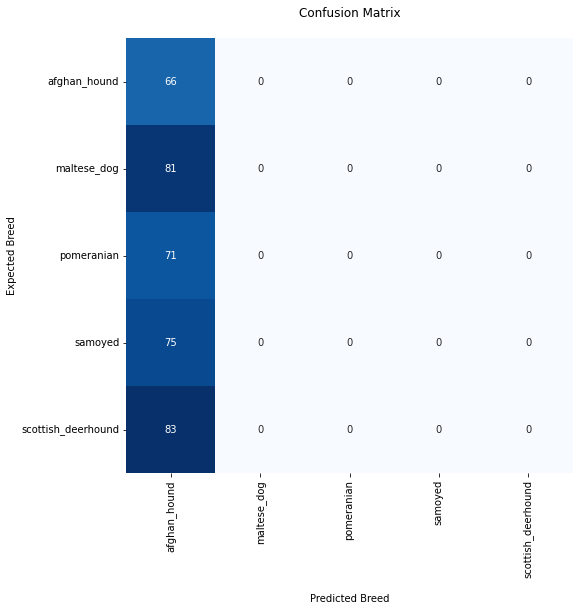




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [13]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalAveragePooling2D(name="global_average_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Layer GlobalMaxPooling

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 504ms/step - loss: 1.6536 - accuracy: 0.1933 - val_loss: 1.5976 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 487ms/step - loss: 1.5558 - accuracy: 0.2744 - val_loss: 1.2861 - val_accuracy: 0.3733 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 488ms/step - loss: 1.2866 - accuracy: 0.4848 - val_loss: 1.1119 - val_accuracy: 0.5893 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 500ms/step - loss: 1.0408 - accuracy: 0.6392 - val_loss: 0.8716 - val_accuracy: 0.6800 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 488ms/step - loss: 0.8737 - accuracy: 0.6752 - val_loss: 0.7365 - val_accuracy: 0.7120 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 13s 487ms/step - loss: 0.7897 - accuracy: 0.6838 - val_loss: 0.6932 - val_accuracy: 0.7120 -

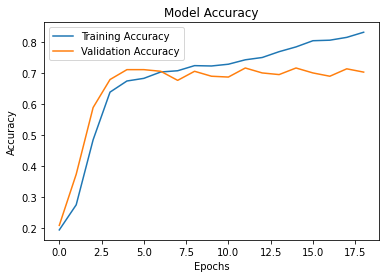

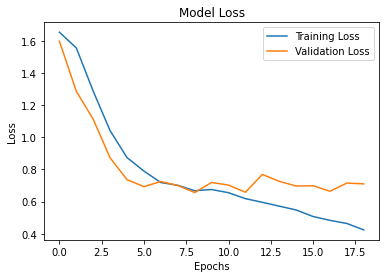

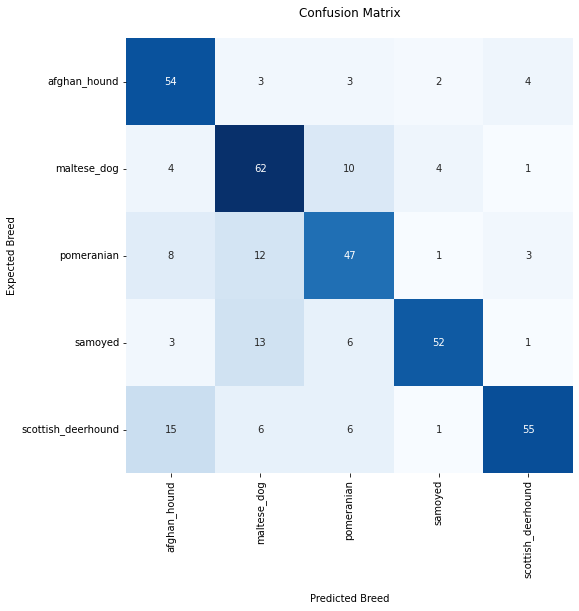




              precision    recall  f1-score   support

           0       0.64      0.82      0.72        66
           1       0.65      0.77      0.70        81
           2       0.65      0.66      0.66        71
           3       0.87      0.69      0.77        75
           4       0.86      0.66      0.75        83

   micro avg       0.72      0.72      0.72       376
   macro avg       0.73      0.72      0.72       376
weighted avg       0.74      0.72      0.72       376
 samples avg       0.72      0.72      0.72       376



In [14]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

In [15]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

## Ajout Layer Convolution

### Ajout d'un bloc de convolution
    - Conv (1024)
    - Conv (1024)
    - Conv (1024)
    - MaxPooling

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 519ms/step - loss: 1.6148 - accuracy: 0.1904 - val_loss: 1.6093 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 496ms/step - loss: 1.6100 - accuracy: 0.1870 - val_loss: 1.6094 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 497ms/step - loss: 1.6098 - accuracy: 0.1944 - val_loss: 1.6093 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 497ms/step - loss: 1.6095 - accuracy: 0.2053 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 498ms/step - loss: 1.6097 - accuracy: 0.1875 - val_loss: 1.6095 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.1990
Epoch 6: ReduceLROnPlateau reducing learning rate 

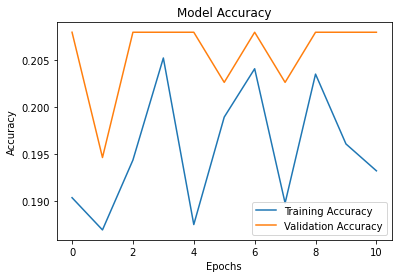

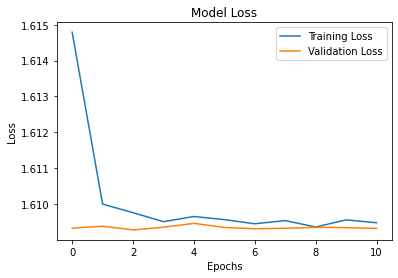

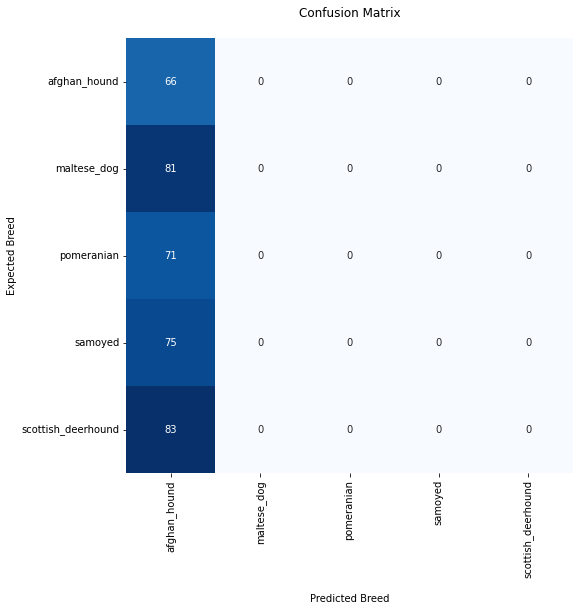




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [16]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = Conv2D(1024, kernel_size=1, strides=1, activation='relu')(headModel)
headModel = Conv2D(1024, kernel_size=1, strides=1, activation='relu')(headModel)
headModel = Conv2D(1024, kernel_size=1, strides=1, activation='relu')(headModel)
headModel = MaxPooling2D(pool_size=(2,2))(headModel)
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Modification head
    - block1_conv1 : kernel_size (3,3) -> (5,5)
    - block1_conv2 : kernel_size (3,3) -> (5,5)

[INFO] creating model...
[INFO] modify head layers model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 14s 502ms/step - loss: 1.6226 - accuracy: 0.1973 - val_loss: 1.6091 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6115 - accuracy: 0.1990 - val_loss: 1.6093 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6144 - accuracy: 0.2041 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 488ms/step - loss: 1.6108 - accuracy: 0.1955 - val_loss: 1.6095 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 487ms/step - loss: 1.6098 - accuracy: 0.1990 - val_loss: 1.6095 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 1.6096 - accuracy: 0.1995
Epoch 6: Reduce

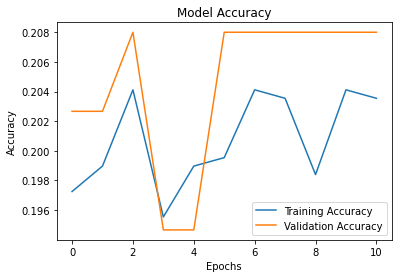

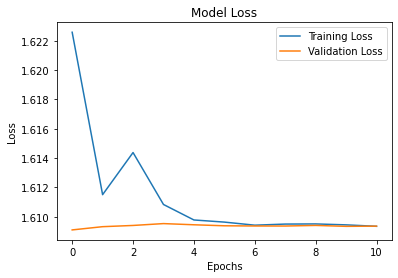

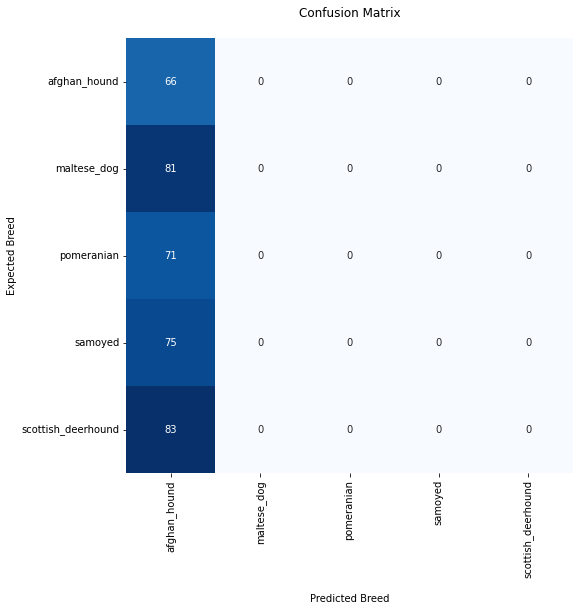




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
print("[INFO] modify head layers model...")
model.get_layer('block1_conv1').kernel_size = (5, 5)
model.get_layer('block1_conv2').kernel_size = (5, 5)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

## Ajout Layer classification

### Ajout de Dense layers
    - Dense(4096, activation ='relu')
    - Dense(4096, activation ='relu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 507ms/step - loss: 1.6130 - accuracy: 0.1893 - val_loss: 1.6095 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 491ms/step - loss: 1.6103 - accuracy: 0.1921 - val_loss: 1.6093 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 491ms/step - loss: 1.6099 - accuracy: 0.1824 - val_loss: 1.6095 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 491ms/step - loss: 1.6099 - accuracy: 0.1852 - val_loss: 1.6094 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 492ms/step - loss: 1.6097 - accuracy: 0.2007 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 13s 491ms/step - loss: 1.6095 - accuracy: 0.2041 - val_loss: 1.6093 - val_accuracy: 0.2080 -

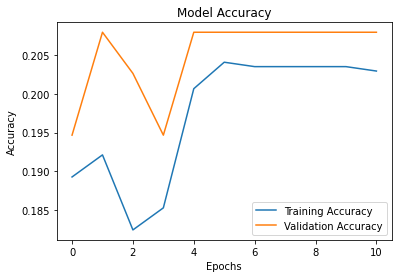

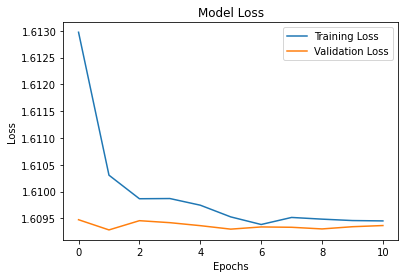

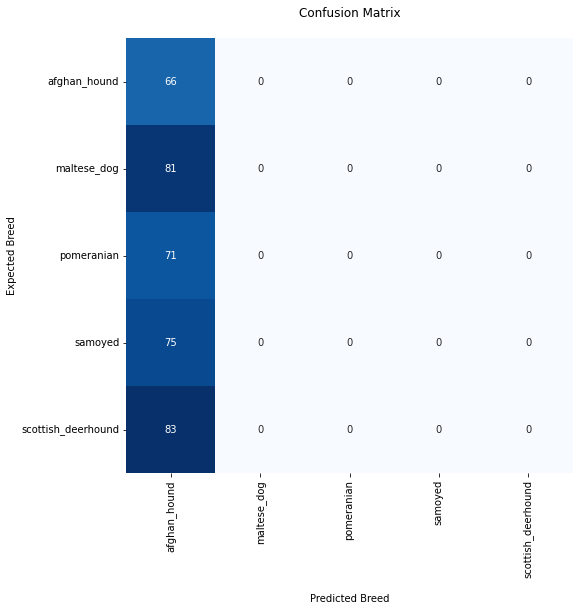




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Ajout de Dense layers
    - Dense(4096, activation ='relu')
    - Dense(1024, activation ='relu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 507ms/step - loss: 1.6364 - accuracy: 0.1847 - val_loss: 1.6100 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6099 - accuracy: 0.2064 - val_loss: 1.6084 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6099 - accuracy: 0.2007 - val_loss: 1.6094 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6099 - accuracy: 0.1875 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6170 - accuracy: 0.2007 - val_loss: 1.6092 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6098 - accuracy: 0.2035 - val_loss: 1.6093 - val_accuracy: 0.2080 -

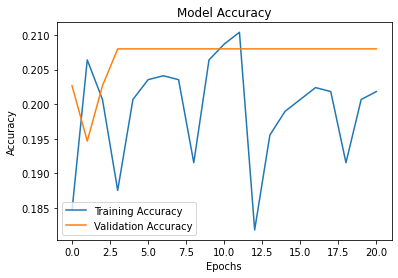

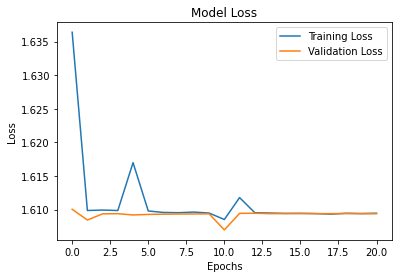

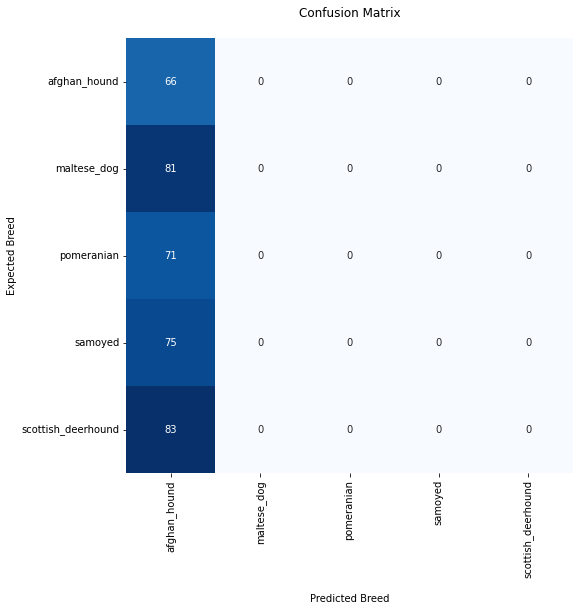




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Modification fonction d'activation 'leakyrelu'
    - Dense(4096, activation ='leakyrelu')
    - Dense(1024, activation ='leakyrelu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 506ms/step - loss: 1.6178 - accuracy: 0.1995 - val_loss: 1.6158 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6119 - accuracy: 0.1967 - val_loss: 1.6094 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6108 - accuracy: 0.1961 - val_loss: 1.6099 - val_accuracy: 0.1947 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6113 - accuracy: 0.2001 - val_loss: 1.6097 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6118 - accuracy: 0.1927 - val_loss: 1.6095 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6111 - accuracy: 0.1990 - val_loss: 1.6101 - val_accuracy: 0.1947 -

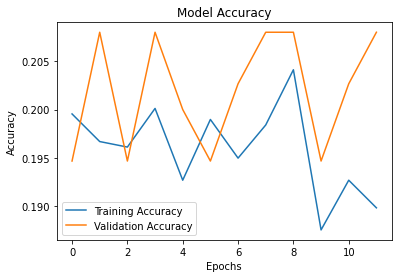

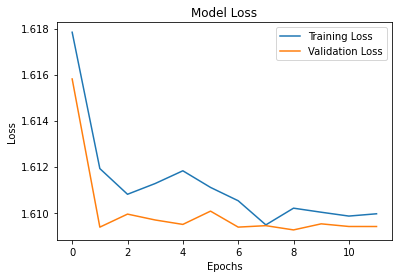

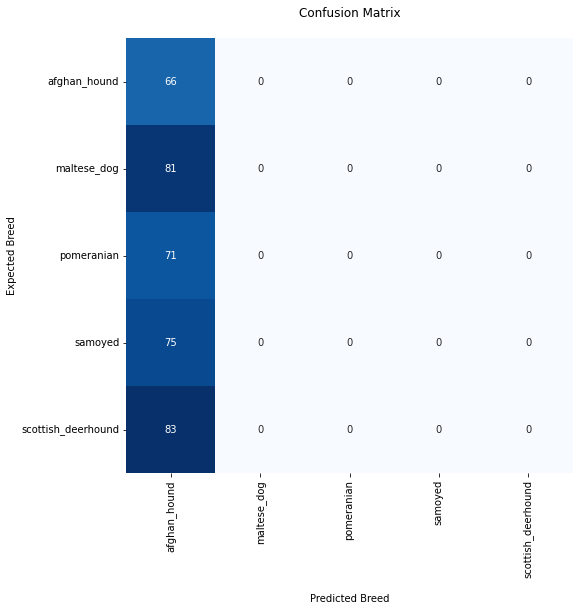




              precision    recall  f1-score   support

           0       0.18      1.00      0.30        66
           1       0.00      0.00      0.00        81
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.18      0.18      0.18       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.03      0.18      0.05       376
 samples avg       0.18      0.18      0.18       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation=None)(headModel)
headModel = LeakyReLU()(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1024, activation=None)(headModel)
headModel = LeakyReLU()(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

### Modification fonction d'activation 'selu'
    - Dense(4096, activation ='selu')
    - Dense(1024, activation ='selu')

[INFO] creating model...
[INFO] compiling model...
[INFO] training model...
Epoch 1/50
27/27 [==============================] - 15s 511ms/step - loss: 1.9060 - accuracy: 0.2024 - val_loss: 1.6510 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6247 - accuracy: 0.1812 - val_loss: 1.6123 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6208 - accuracy: 0.1847 - val_loss: 1.6111 - val_accuracy: 0.2027 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 13s 490ms/step - loss: 1.6164 - accuracy: 0.1984 - val_loss: 1.6395 - val_accuracy: 0.2080 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6282 - accuracy: 0.2156 - val_loss: 1.6145 - val_accuracy: 0.2000 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 13s 489ms/step - loss: 1.6286 - accuracy: 0.1984 - val_loss: 1.6172 - val_accuracy: 0.2000 -

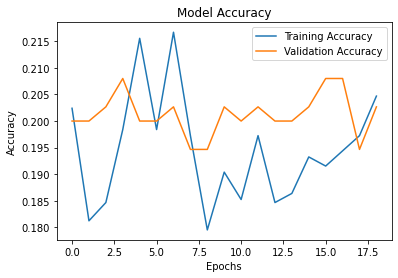

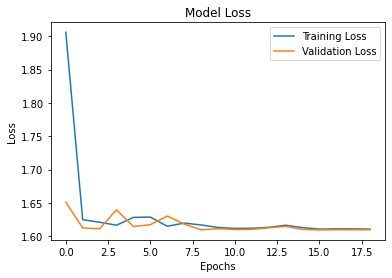

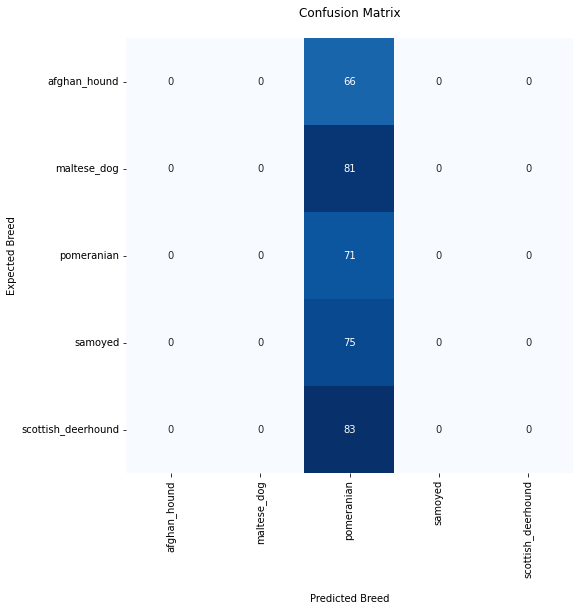




              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.00      0.00      0.00        81
           2       0.19      1.00      0.32        71
           3       0.00      0.00      0.00        75
           4       0.00      0.00      0.00        83

   micro avg       0.19      0.19      0.19       376
   macro avg       0.04      0.20      0.06       376
weighted avg       0.04      0.19      0.06       376
 samples avg       0.19      0.19      0.19       376



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
print("[INFO] creating model...")
baseModel = VGG16(weights=None, include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(4096, activation="selu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1024, activation="selu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

#Transfer learning VGG16 (imagenet)

## Meilleur model from scratch avec import poids "imagenet"

[INFO] creating model...
58900480/58889256 [==============================] - 1s 0us/step
[INFO] freeze weights...
- [input_10] : train_state -> False
- [block1_conv1] : train_state -> False
- [block1_conv2] : train_state -> False
- [block1_pool] : train_state -> False
- [block2_conv1] : train_state -> False
- [block2_conv2] : train_state -> False
- [block2_pool] : train_state -> False
- [block3_conv1] : train_state -> False
- [block3_conv2] : train_state -> False
- [block3_conv3] : train_state -> False
- [block3_pool] : train_state -> False
- [block4_conv1] : train_state -> False
- [block4_conv2] : train_state -> False
- [block4_conv3] : train_state -> False
- [block4_pool] : train_state -> False
- [block5_conv1] : train_state -> False
- [block5_conv2] : train_state -> False
- [block5_conv3] : train_state -> False
- [block5_pool] : train_state -> False
- [global_max_pooling2d] : train_state -> True
- [dropout_17] : train_state -> True
- [dense_17] : train_state -> True
[INFO] VGG16 we

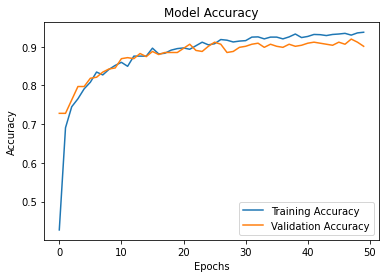

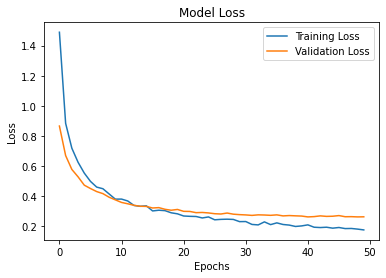

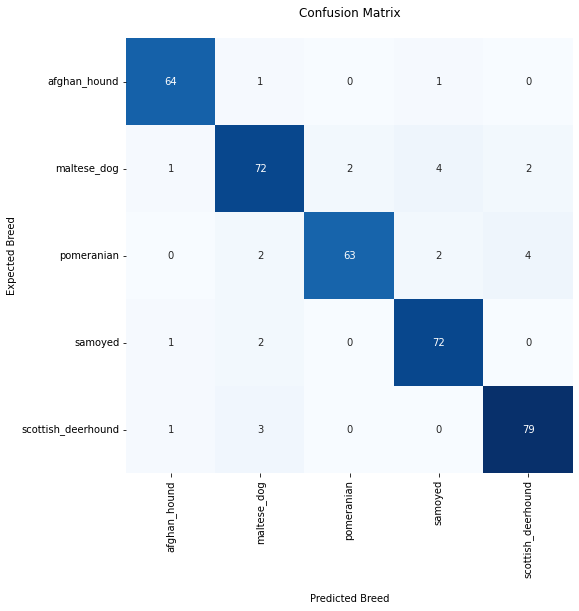




              precision    recall  f1-score   support

           0       0.96      0.97      0.96        66
           1       0.90      0.89      0.89        81
           2       0.97      0.89      0.93        71
           3       0.91      0.96      0.94        75
           4       0.93      0.95      0.94        83

   micro avg       0.93      0.93      0.93       376
   macro avg       0.93      0.93      0.93       376
weighted avg       0.93      0.93      0.93       376
 samples avg       0.93      0.93      0.93       376



In [22]:
print("[INFO] creating model...")
baseModel = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224,224,3)))
headModel = baseModel.output
headModel = GlobalMaxPooling2D(name="global_max_pooling2d")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

print("[INFO] freeze weights...")
baseModel.trainable = False
for layer in model.layers:
    print(f'- [{layer.name}] : train_state -> {layer.trainable}')
print("[INFO] VGG16 weights frozen...")

print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

## Fine-Tuning Step 1

[INFO] unfreeze block_5 weights...
- [input_10] : train_state -> False
- [block1_conv1] : train_state -> False
- [block1_conv2] : train_state -> False
- [block1_pool] : train_state -> False
- [block2_conv1] : train_state -> False
- [block2_conv2] : train_state -> False
- [block2_pool] : train_state -> False
- [block3_conv1] : train_state -> False
- [block3_conv2] : train_state -> False
- [block3_conv3] : train_state -> False
- [block3_pool] : train_state -> False
- [block4_conv1] : train_state -> False
- [block4_conv2] : train_state -> False
- [block4_conv3] : train_state -> False
- [block4_pool] : train_state -> False
- [block5_conv1] : train_state -> True
- [block5_conv2] : train_state -> True
- [block5_conv3] : train_state -> True
- [block5_pool] : train_state -> True
- [global_max_pooling2d] : train_state -> True
- [dropout_17] : train_state -> True
- [dense_17] : train_state -> True
[INFO] re-compiling model...
[INFO] training model...
Epoch 1/20
27/27 [===========================

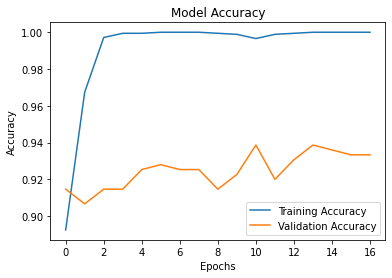

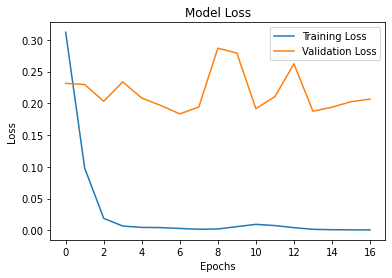

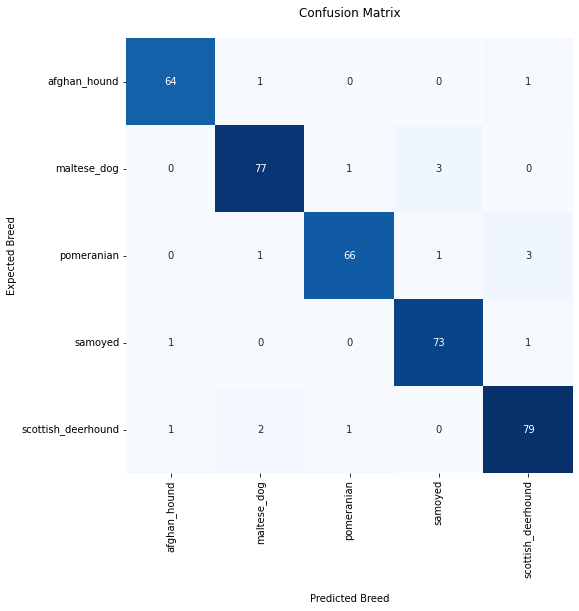




              precision    recall  f1-score   support

           0       0.97      0.97      0.97        66
           1       0.95      0.95      0.95        81
           2       0.97      0.93      0.95        71
           3       0.95      0.97      0.96        75
           4       0.94      0.95      0.95        83

   micro avg       0.95      0.95      0.95       376
   macro avg       0.96      0.96      0.96       376
weighted avg       0.95      0.95      0.95       376
 samples avg       0.95      0.95      0.95       376



In [23]:
print("[INFO] unfreeze block_5 weights...")
unfreeze_layers = [
    'block5_conv1',
    'block5_conv2',
    'block5_conv3',
    'block5_pool'
]
for layer in model.layers:
    if layer.name in unfreeze_layers:
        layer.trainable = True
    print(f'- [{layer.name}] : train_state -> {layer.trainable}')

print("[INFO] re-compiling model...")
opt = Adam(learning_rate=1e-4)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=20, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)

In [25]:
model.save('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/vgg16_5_classes')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/vgg16_5_classes/assets


## Fine-Tuning Step 2

[INFO] unfreeze block_4 weights...
- [input_10] : train_state -> False
- [block1_conv1] : train_state -> False
- [block1_conv2] : train_state -> False
- [block1_pool] : train_state -> False
- [block2_conv1] : train_state -> False
- [block2_conv2] : train_state -> False
- [block2_pool] : train_state -> False
- [block3_conv1] : train_state -> False
- [block3_conv2] : train_state -> False
- [block3_conv3] : train_state -> False
- [block3_pool] : train_state -> False
- [block4_conv1] : train_state -> True
- [block4_conv2] : train_state -> True
- [block4_conv3] : train_state -> True
- [block4_pool] : train_state -> True
- [block5_conv1] : train_state -> True
- [block5_conv2] : train_state -> True
- [block5_conv3] : train_state -> True
- [block5_pool] : train_state -> True
- [global_max_pooling2d] : train_state -> True
- [dropout_17] : train_state -> True
- [dense_17] : train_state -> True
[INFO] re-compiling model...
[INFO] training model...
Epoch 1/20
27/27 [==============================]

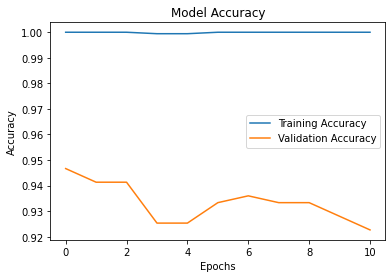

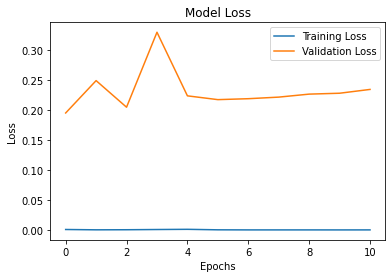

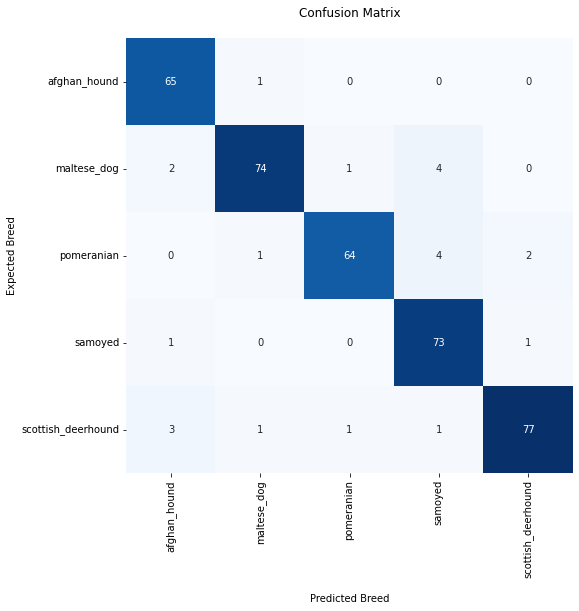




              precision    recall  f1-score   support

           0       0.92      0.98      0.95        66
           1       0.96      0.91      0.94        81
           2       0.97      0.90      0.93        71
           3       0.89      0.97      0.93        75
           4       0.96      0.93      0.94        83

   micro avg       0.94      0.94      0.94       376
   macro avg       0.94      0.94      0.94       376
weighted avg       0.94      0.94      0.94       376
 samples avg       0.94      0.94      0.94       376



In [26]:
print("[INFO] unfreeze block_4 weights...")
unfreeze_layers = [
    'block4_conv1',
    'block4_conv2',
    'block4_conv3',
    'block4_pool'
]
for layer in model.layers:
    if layer.name in unfreeze_layers:
        layer.trainable = True
    print(f'- [{layer.name}] : train_state -> {layer.trainable}')

print("[INFO] re-compiling model...")
opt = Adam(learning_rate=1e-5)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

print("[INFO] training model...")
history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=20, 
    callbacks=callbacks,
    verbose=1
    )

model_report(model, history, X_test, y_test, lb)